In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

Entropy and Information Gain

In [2]:
def calculate_entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy
def information_gain(parent_entropy, left_y, right_y):
    n_total = len(left_y) + len(right_y)
    entropy_left = calculate_entropy(left_y)
    entropy_right = calculate_entropy(right_y)
    
    weight_left = len(left_y) / n_total
    weight_right = len(right_y) / n_total
    
    children_entropy = weight_left * entropy_left + weight_right * entropy_right
    return parent_entropy - children_entropy

Node Class

In [3]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value

Decision Tree Classifier

In [ ]:
class DecisionTreeClassifierScratch:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.feature_importances_ = {}

    def _best_split(self, X, y):
        rows, cols = X.shape
        if rows <= 1:
            return None, None, None, None, None

        parent_entropy = calculate_entropy(y)
        best_gain = -1
        best_feature_index = None
        best_threshold = None
        for feature_index in range(cols):
            X_column = X[:, feature_index]
            distinct_values = np.unique(X_column)
            candidate_thresholds = (distinct_values[:-1] + distinct_values[1:]) / 2
            
            for threshold in candidate_thresholds:
                left_indices = np.where(X_column <= threshold)[0]
                right_indices = np.where(X_column > threshold)[0]
                
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                left_y, right_y = y[left_indices], y[right_indices]
                gain = information_gain(parent_entropy, left_y, right_y)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold, best_gain

    def _build_tree(self, X, y, current_depth=0):
        n_samples, n_features = X.shape
        unique_classes, counts = np.unique(y, return_counts=True)
        majority_class = unique_classes[np.argmax(counts)]
        if len(unique_classes) == 1:
            return Node(value=majority_class)
        
        if self.max_depth is not None and current_depth >= self.max_depth:
            return Node(value=majority_class)
            
        if n_samples < self.min_samples_split:
            return Node(value=majority_class)
        
        feature_index, threshold, gain = self._best_split(X, y)

        if feature_index is None or gain <= 1e-6:
            return Node(value=majority_class)
        
        self.feature_importances_[feature_index] = self.feature_importances_.get(feature_index, 0) + gain
        left_indices = np.where(X[:, feature_index] <= threshold)[0]
        right_indices = np.where(X[:, feature_index] > threshold)[0]

        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]
        left_child = self._build_tree(X_left, y_left, current_depth + 1)
        right_child = self._build_tree(X_right, y_right, current_depth + 1)

        return Node(feature_index=feature_index, threshold=threshold, 
                    left=left_child, right=right_child, gain=gain)

    def fit(self, X, y):
        self.feature_importances_ = {}
        self.tree = self._build_tree(X, y, current_depth=0)
        return self

    def _predict(self, x, tree):
        if tree.value is not None:
            return tree.value
        
        feature_value = x[tree.feature_index]
        if feature_value <= tree.threshold:
            return self._predict(x, tree.left)
        else:
            return self._predict(x, tree.right)

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])


Data Loading and Splitting

In [5]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

print(f"Total samples: {len(X)}")
print(f"Features: {len(feature_names)}")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.5 / (1 - 0.15), random_state=42, stratify=y_train_val
)

print("-" * 30)
print(f"Train samples (70%): {len(X_train)}")
print(f"Validation samples (15%): {len(X_val)}")
print(f"Test samples (15%): {len(X_test)}")

Total samples: 569
Features: 30
------------------------------
Train samples (70%): 198
Validation samples (15%): 285
Test samples (15%): 86


Hyperparameter Tuning

In [6]:
max_depth_grid = [2, 4, 6, 8, 10]
min_samples_split_grid = [2, 5, 10]

best_params = {'max_depth': None, 'min_samples_split': None}
best_val_accuracy = -1
tuning_results = []

print("--- Tuning Progress ---")

for max_depth in max_depth_grid:
    for min_samples_split in min_samples_split_grid:
        model = DecisionTreeClassifierScratch(max_depth=max_depth, min_samples_split=min_samples_split)
        model.fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        
        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)
        
        tuning_results.append({
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'Train Accuracy': round(train_acc, 4),
            'Validation Accuracy': round(val_acc, 4),
            'Overfitting Gap': round(train_acc - val_acc, 4)
        })
        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_params['max_depth'] = max_depth
            best_params['min_samples_split'] = min_samples_split

print("Tuning Complete.")

--- Tuning Progress ---
Tuning Complete.


Tuning Analysis

In [7]:
tuning_df = pd.DataFrame(tuning_results)

print(f"Best Hyperparameters: max_depth={best_params['max_depth']}, min_samples_split={best_params['min_samples_split']}")
print(f"Best Validation Accuracy: {round(best_val_accuracy, 4)}")
print("-" * 40)

print("Impact of Max Depth (with min_samples_split=2):")
depth_analysis_df = tuning_df[tuning_df['min_samples_split'] == 2].sort_values('max_depth')
print(depth_analysis_df[['max_depth', 'Train Accuracy', 'Validation Accuracy', 'Overfitting Gap']].to_markdown(index=False))

Best Hyperparameters: max_depth=2, min_samples_split=2
Best Validation Accuracy: 0.9368
----------------------------------------
Impact of Max Depth (with min_samples_split=2):
|   max_depth |   Train Accuracy |   Validation Accuracy |   Overfitting Gap |
|------------:|-----------------:|----------------------:|------------------:|
|           2 |           0.9545 |                0.9368 |            0.0177 |
|           4 |           1      |                0.9298 |            0.0702 |
|           6 |           1      |                0.9298 |            0.0702 |
|           8 |           1      |                0.9298 |            0.0702 |
|          10 |           1      |                0.9298 |            0.0702 |


Final Model Training

In [8]:
X_final_train = np.concatenate((X_train, X_val))
y_final_train = np.concatenate((y_train, y_val))

final_model = DecisionTreeClassifierScratch(
    max_depth=best_params['max_depth'], 
    min_samples_split=best_params['min_samples_split']
)

print(f"Training Final Model with Depth {best_params['max_depth']}...")
final_model.fit(X_final_train, y_final_train)
print("Done.")

Training Final Model with Depth 2...
Done.


Final Test Evaluation

In [9]:
y_test_pred = final_model.predict(X_test)

final_acc = accuracy_score(y_test, y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None, labels=[0, 1])

metrics_table = pd.DataFrame({
    'Class': data.target_names,
    'Precision': [round(p, 4) for p in precision],
    'Recall': [round(r, 4) for r in recall],
    'F1-Score': [round(f, 4) for f in f1]
})

print(f"Overall Test Accuracy: {round(final_acc, 4)}")
print("\nDetailed Metrics:")
print(metrics_table.to_markdown(index=False))

cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Malignant (0)', 'Actual Benign (1)'], 
                     columns=['Predicted Malignant (0)', 'Predicted Benign (1)'])
print("\nConfusion Matrix:")
print(cm_df.to_markdown())

Overall Test Accuracy: 0.8837

Detailed Metrics:
| Class     |   Precision |   Recall |   F1-Score |
|:----------|------------:|---------:|-----------:|
| malignant |      0.7619 |   1      |     0.8649 |
| benign    |      1      |   0.8148 |     0.898  |

Confusion Matrix:
|                      |   Predicted Malignant (0) |   Predicted Benign (1) |
|:---------------------|--------------------------:|-----------------------:|
| Actual Malignant (0) |                        32 |                      0 |
| Actual Benign (1)    |                        10 |                     44 |


Depth VS Accuracy

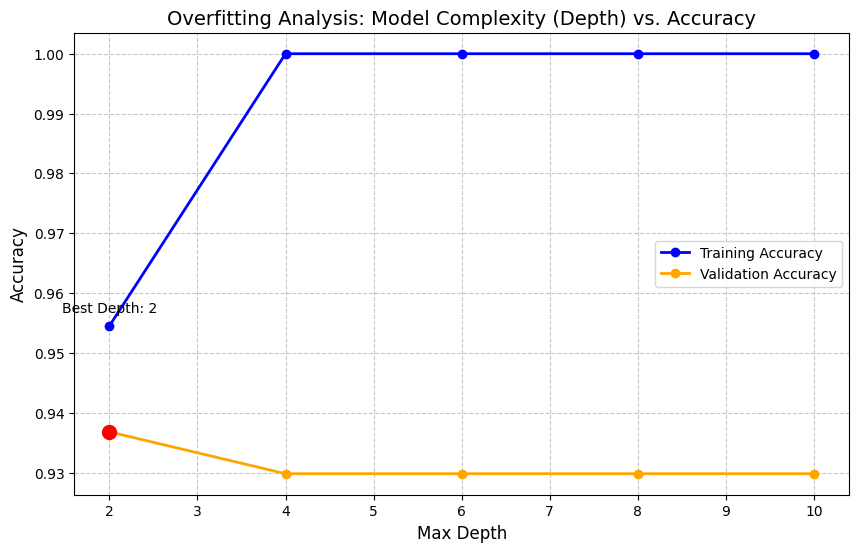

In [10]:
plot_df = tuning_df[tuning_df['min_samples_split'] == 2]

plt.figure(figsize=(10, 6))
plt.plot(plot_df['max_depth'], plot_df['Train Accuracy'], 
         marker='o', label='Training Accuracy', color='blue', linewidth=2)
plt.plot(plot_df['max_depth'], plot_df['Validation Accuracy'], 
         marker='o', label='Validation Accuracy', color='orange', linewidth=2)

plt.title('Overfitting Analysis: Model Complexity (Depth) vs. Accuracy', fontsize=14)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

best_depth = best_params['max_depth']
best_acc = best_val_accuracy
plt.scatter([best_depth], [best_acc], color='red', s=100, zorder=5, label='Best Model')
plt.annotate(f'Best Depth: {best_depth}', (best_depth, best_acc), 
             xytext=(best_depth, best_acc + 0.02), ha='center')

plt.show()

Feature Importance Rankning

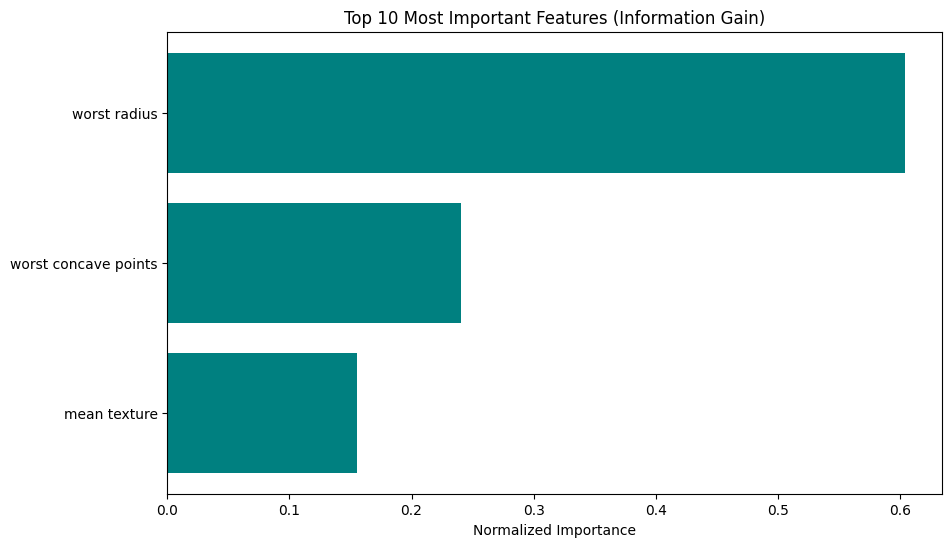

| Feature              |   Contribution |
|:---------------------|---------------:|
| worst radius         |         0.6043 |
| worst concave points |         0.2405 |
| mean texture         |         0.1552 |


In [11]:
# 1. Get raw importance scores from the trained model
importance = final_model.feature_importances_
total_gain = sum(importance.values())

if total_gain > 0:
    # 2. Normalize and Sort
    normalized_importance = {
        feature_names[k]: v / total_gain 
        for k, v in sorted(importance.items(), key=lambda item: item[1], reverse=True)
    }
    
    # 3. Create DataFrame
    importance_df = pd.DataFrame(list(normalized_importance.items()), 
                                 columns=['Feature', 'Contribution'])
    
    # 4. Plot Top 10 Features
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(10)
    plt.barh(top_features['Feature'], top_features['Contribution'], color='teal')
    plt.gca().invert_yaxis() # Highest importance at the top
    plt.title('Top 10 Most Important Features (Information Gain)')
    plt.xlabel('Normalized Importance')
    plt.show()

    # 5. Print Table
    print(importance_df.head(10).to_markdown(index=False, floatfmt=".4f"))
else:
    print("Feature Importance could not be calculated (Total gain was zero).")

Final Analysis Summary

In [12]:
print("--- ANALYSIS SUMMARY ---")
print(f"1. Optimal Complexity: The model performed best at Max Depth = {best_params['max_depth']}.")

overfitting_gap = plot_df[plot_df['max_depth'] == best_params['max_depth']]['Overfitting Gap'].values[0]
print(f"2. Overfitting Control: At this depth, the gap between Train/Val accuracy is {round(overfitting_gap, 4)}.")
if overfitting_gap > 0.10:
    print("   (Note: The gap is significant, suggesting some overfitting still exists.)")
else:
    print("   (Note: The gap is small, suggesting the model generalizes well.)")

top_feature = importance_df.iloc[0]['Feature']
print(f"3. Key Driver: The single most important feature for diagnosis was '{top_feature}'.")

--- ANALYSIS SUMMARY ---
1. Optimal Complexity: The model performed best at Max Depth = 2.
2. Overfitting Control: At this depth, the gap between Train/Val accuracy is 0.0177.
   (Note: The gap is small, suggesting the model generalizes well.)
3. Key Driver: The single most important feature for diagnosis was 'worst radius'.
